# Setup

In [ ]:
!pip install scipy==1.6.3
!pip install scikit_optimize==0.8.1
!pip install scikit_learn==0.24.2
! git clone https://github.com/zykhoo/SeparableNNs.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 27.4 MB 1.9 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 101 kB 3.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 1.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# NN takes in p, q, dq, dp, and learns the Hamiltonian. The derivative of the Hamiltonian is used for integration

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.nn.utils.prune as prune
import numpy as np
import os
import time
from tqdm import tqdm
import math

# define model
def softplus(x):
    return torch.log(torch.exp(x)+1)

from sklearn.model_selection import train_test_split


# class sepNet(nn.Module):

#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(sepNet , self).__init__()
#         self.mask1 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(input_size/2))),torch.zeros((1,int(input_size/2)))),1),0).repeat(int(hidden_size1),1),
#             torch.squeeze(torch.cat((torch.zeros((1,int(input_size/2))),torch.ones((1,int(input_size/2)))),1),0).repeat(int(hidden_size1),1)),0)
#         self.mask2 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(hidden_size1))),torch.zeros((1,int(hidden_size1)))),1),0).repeat(int(hidden_size2),1),
#                     torch.squeeze(torch.cat((torch.zeros((1,int(hidden_size1))),torch.ones((1,int(hidden_size1)))),1),0).repeat(int(hidden_size2),1)),0)
#         self.mask3 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(hidden_size2))),torch.zeros((1,int(hidden_size2)))),1),0).repeat(int(output_size),1),
#                     torch.squeeze(torch.cat((torch.zeros((1,int(hidden_size2))),torch.ones((1,int(hidden_size2)))),1),0).repeat(int(output_size),1)),0)
#         self.hidden_layer_1 = nn.Linear( input_size, hidden_size1*2, bias=True)
#         with torch.no_grad():
#             self.hidden_layer_1.weight.mul_(self.mask1)
#         self.hidden_layer_2 = nn.Linear( hidden_size1*2, hidden_size2*2, bias=True)
#         with torch.no_grad():
#             self.hidden_layer_2.weight.mul_(self.mask2)
#         self.output_layer = nn.Linear( hidden_size2*2, output_size*2 , bias=True)
#         with torch.no_grad():
#             self.output_layer.weight.mul_(self.mask3)
#         prune.custom_from_mask(self.hidden_layer_1, name='weight', mask=self.mask1)
#         prune.custom_from_mask(self.hidden_layer_2, name='weight', mask=self.mask2)
#         prune.custom_from_mask(self.output_layer, name='weight', mask=self.mask3)
        
#     def forward(self, x):
#         x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
#         x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
#         x = self.output_layer(x)
#         x = torch.sum(x)
#         return x


# PINN
class Net(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(Net , self).__init__()
        self.hidden_layer_1 = nn.Linear( input_size, hidden_size, bias=True)
        self.hidden_layer_2 = nn.Linear( hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear( hidden_size, output_size , bias=True)
        
    def forward(self, x):
        x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
        x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
        x = self.output_layer(x)

        return x

class SumNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(SumNet , self).__init__()
        self.hidden_layer_1 = nn.Linear( input_size, hidden_size, bias=True)
        self.hidden_layer_2 = nn.Linear( hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear( hidden_size, 2 , bias=True)
        
    def forward(self, x):
        x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
        x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
        x = self.output_layer(x)
        x = torch.sum(x)

        return x

# calculate loss
def lossfuc(model,mat,x,y,device,x0,H0,dim,c1=1,c2=1,c3=1,c4=1,verbose=False):
    dim = int(wholemat.shape[1]/2)
    f3=(model(torch.tensor([[x0]*dim]).to(device))-torch.tensor([[H0]]).to(device))**2
    dH=torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1),create_graph=True, allow_unused=True)[0]
    dHdq=dH[:,:int(dim/2)]
    dHdp=dH[:,int(dim/2):]
    qprime=(mat[:,dim:int(3*dim/2)])
    pprime=(mat[:,int(3*dim/2):])
    assert dHdq.shape[1] == int(dim/2)
    assert dHdp.shape[1] == int(dim/2)
    assert qprime.shape[1] == int(dim/2)
    assert pprime.shape[1] == int(dim/2)
    f1=torch.mean((dHdp-qprime)**2,dim=0)
    # print(dHdq, pprime)
    f2=torch.mean((dHdq+pprime)**2,dim=0)
    f4=torch.mean((dHdq*qprime+dHdp*pprime)**2,dim=0)
    loss=torch.mean(c1*f1+c2*f2+c3*f3+c4*f4)
    if loss > 1000: print("errors:", f1, f2, f3, f4)
    meanf1,meanf2,meanf3,meanf4=torch.mean(c1*f1),torch.mean(c2*f2),torch.mean(c3*f3),torch.mean(c4*f4)
    if verbose:
      print(x)
      print(meanf1,meanf2,meanf3,meanf4)
      print(loss,meanf1,meanf2,meanf3,meanf4)
    return loss,meanf1,meanf2,meanf3,meanf4


def data_preprocessing(start_train, final_train,device):       
    # wholemat=[]
    # for i in range(len(start_train[0,:])):
    #     wholemat.append(np.vstack((
    #         np.hstack((start_train[:,i], (final_train[:,i]-start_train[:,i])/h)),
    #         np.hstack((final_train[:,i], (final_train[:,i]-start_train[:,i])/h)))))
    wholemat = np.hstack((start_train.transpose(), final_train.transpose()))

    wholemat =torch.tensor(wholemat)
    wholemat=wholemat.to(device)

    wholemat,evalmat=train_test_split(wholemat, train_size=0.8, random_state=1)

    return wholemat,evalmat

## train

# evaluate loss of dataset 
def get_loss(model,device,initial_conditions,bs,x0,H0,dim,wholemat,evalmat,c1,c2,c3,c4,trainset=False,verbose=False):
    # this function is used to calculate average loss of a whole dataset
    # rootpath: path of set to be calculated loss
    # model: model
    # trainset: is training set or not


    if trainset:
        mat=wholemat
    else:
        mat=evalmat
    avg_loss=0
    avg_f1=0
    avg_f2=0
    avg_f3=0
    avg_f4=0
    for count in range(0,len(mat),bs):
      curmat=mat[count:count+bs]
      x=Variable((curmat[:,:dim]).float(),requires_grad=True)
      y=model(x)
      x=x.to(device)
      loss,f1,f2,f3,f4=lossfuc(model,curmat,x,y,device,x0,H0,dim,c1,c2,c3,c4)
      avg_loss+=loss.detach().cpu().item()
      avg_f1+=f1.detach().cpu().item()
      avg_f2+=f2.detach().cpu().item()
      avg_f3+=f3.detach().cpu().item()
      avg_f4+=f4.detach().cpu().item()
    num_batches=len(mat)//bs
    avg_loss/=num_batches
    avg_f1/=num_batches
    avg_f2/=num_batches
    avg_f3/=num_batches
    avg_f4/=num_batches
    if verbose:
        print(' loss=',avg_loss,' f1=',avg_f1,' f2=',avg_f2,' f3=',avg_f3,' f4=',avg_f4)
    return avg_loss


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            上次验证集损失值改善后等待几个epoch
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            如果是True，为每个验证集损失值改善打印一条信息
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            监测数量的最小变化，以符合改进的要求
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if abs(self.counter-self.patience)<5:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''
        Saves model when validation loss decrease.
        验证损失减少时保存模型。
        '''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), 'checkpoint.pt')     # 这里会存储迄今最优模型的参数
        torch.save(model, 'checkpoint.pt')                 # 这里会存储迄今最优的模型
        self.val_loss_min = val_loss

def train(net,bs,num_epoch,initial_conditions,device,wholemat,evalmat,x0,H0,dim,LR,patience,c1,c2,c3,c4):
    # function of training process
    # net: the model
    # bs: batch size 
    # num_epoch: max of epoch to run
    # initial_conditions: number of trajectory in train set
    # patience: EarlyStopping parameter
    # c1~c4: hyperparameter for loss function


    avg_lossli,avg_f1li,avg_f2li,avg_f3li,avg_f4li=[],[],[],[],[]
    avg_vallosses=[]
    
    start = time.time()
    lr = LR # initial learning rate
    net=net.to(device)

    early_stopping = EarlyStopping(patience=patience, verbose=False,delta=0.00001) # delta
    optimizer=torch.optim.Adam(net.parameters() , lr=lr )
    for epoch in range(num_epoch):

        running_loss=0

        running_f1=0
        running_f2=0
        running_f3=0
        running_f4=0
        num_batches=0
        
        # train
        shuffled_indices=torch.randperm(len(wholemat))
        net.train()
        for count in range(0,len(wholemat),bs):
            optimizer.zero_grad()

            indices=shuffled_indices[count:count+bs]
            mat=wholemat[indices]

            x=Variable(torch.tensor(mat[:,:dim]).float(),requires_grad=True)
            y=net(x)

            loss,f1,f2,f3,f4=lossfuc(net,mat,x,y,device,x0,H0,dim,c1,c2,c3,c4)  
            loss.backward()
            torch.nn.utils.clip_grad_norm(net.parameters(), 1)

            optimizer.step()

            # compute some stats
            running_loss += loss.detach().item()
            running_f1 += f1.detach().item()
            running_f2 += f2.detach().item()
            running_f3 += f3.detach().item()
            running_f4 += f4.detach().item()

            num_batches+=1
            torch.cuda.empty_cache()



        avg_loss = running_loss/num_batches
        avg_f1 = running_f1/num_batches
        avg_f2 = running_f2/num_batches
        avg_f3 = running_f3/num_batches
        avg_f4 = running_f4/num_batches
        elapsed_time = time.time() - start
        
        avg_lossli.append(avg_loss)
        avg_f1li.append(avg_f1)
        avg_f2li.append(avg_f2)
        avg_f3li.append(avg_f3)
        avg_f4li.append(avg_f4)
        
        
        # evaluate
        net.eval()
        avg_val_loss=get_loss(net,device,len(evalmat),bs,x0,H0,dim,wholemat,evalmat,c1,c2,c3,c4)
        avg_vallosses.append(avg_val_loss)
        
        if epoch % 100 == 0 : 
            print(' ')
            print('epoch=',epoch, ' time=', elapsed_time,
                  ' loss=', avg_loss ,' val_loss=',avg_val_loss,' f1=', avg_f1 ,' f2=', avg_f2 ,
                  ' f3=', avg_f3 ,' f4=', avg_f4 , 'num_batches=', num_batches, 'percent lr=', optimizer.param_groups[0]["lr"] )
        
        
        
        early_stopping(avg_val_loss,net)
        if early_stopping.early_stop:
            print('Early Stopping')
            break
            
    net=torch.load('checkpoint.pt')
    return net,epoch,avg_vallosses,avg_lossli,avg_f1li,avg_f2li,avg_f3li,avg_f4li

class splitBalancedLinear(nn.Module):

    def __init__(self, input_size, output_size):
        # output_size is the size of one of the two parallel networks
        super(splitBalancedLinear , self).__init__()
        self.input_size, self.output_size = input_size, output_size
        weights = torch.Tensor(2,self.input_size,self.output_size)
        self.weights = nn.Parameter(weights)
        bias = torch.Tensor(2,1,self.output_size)
        self.bias = nn.Parameter(bias)

        # initialise weights and bias
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) 
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)  # bias init
        
    def forward(self, x):
        # print(self.weights, self.bias)
        # print("mul", torch.einsum('ijk,ikl->ijl', x, self.weights))
        # print("add", torch.add(torch.einsum('ijk,ikl->ijl', x, self.weights), self.bias))
        return torch.add(torch.einsum('ijk,ikl->ijl', x, self.weights), self.bias)
        # return F.linear(x, self.weights, self.bias)

class sepNet(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(sepNet , self).__init__()
        self.hidden_layer_1 = splitBalancedLinear(input_size, hidden_size1)
        self.hidden_layer_2 = splitBalancedLinear(hidden_size1, hidden_size2)
        self.output_layer = splitBalancedLinear(hidden_size2, output_size)
        
    def forward(self, x):
        # print("input", x.shape)
        # print(x)
        x = torch.stack((x[:,:int(x.shape[-1]/2)],x[:,int(x.shape[-1]/2):]))
        # print(x)
        # print("initial", x.shape)
        x = softplus(self.hidden_layer_1(x)) 
        # print(x)
        # print("hl1", x.shape)
        x = softplus(self.hidden_layer_2(x)) 
        # print(x)
        # print("hl2", x.shape)
        x = self.output_layer(x)
        # print(x)
        # print("output", x.shape)
        x = torch.sum(x)
        return x

In [ ]:
def get_secondgrad(model, z,device):
      inputs=Variable(z.clone().detach()).requires_grad_(True).to(device)
      out=model(inputs.float())
      dH=torch.autograd.grad(out, inputs, grad_outputs=out.data.new(out.shape).fill_(1),create_graph=True)[0]
      d2H = 0
      for i in range(dH.shape[1]):
        secondderiv=torch.autograd.grad(dH[:,i], inputs, grad_outputs=dH[:,i].data.new(dH[:,i].shape).fill_(1),create_graph=True)[0]
        if i < int(dH.shape[1]/2):
          d2H += torch.mean(torch.square(secondderiv[:,int(dH.shape[1]/2):]))
        else:
          d2H += torch.mean(torch.square(secondderiv[:,:int(dH.shape[1]/2)]))
      return d2H.detach().cpu().numpy()

# $x_0 \times x_1 \times x_2\times y_0 \times y_1\times y_2$

In [ ]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from matplotlib import cm
from SeparableNNs.models import PINN
import torch
from SeparableNNs import metrics
import numpy as np
from SeparableNNs import groundtruth_2dim
from tqdm import tqdm
import torch.optim as optim
import sympy as sp

a = sp.symbols('a')
b = sp.symbols('b')
c = sp.symbols('c')
x = sp.symbols('x')
y = sp.symbols('y')
z = sp.symbols('z')

experiment,sys,dim = "NN","abcxyz",6

H = a*b*c*x*y*z
f0 = sp.lambdify((a,b,c,x,y,z), H.diff(x))
f1 = sp.lambdify((a,b,c,x,y,z), H.diff(y))
f2 = sp.lambdify((a,b,c,x,y,z), H.diff(z))
f3 = sp.lambdify((a,b,c,x,y,z), H.diff(a))
f4 = sp.lambdify((a,b,c,x,y,z), H.diff(b))
f5 = sp.lambdify((a,b,c,x,y,z), H.diff(c))

spacedim = [(-1.,1.)] 
h= 0.01
x0, H0 = 0.,0.
initialcon = [64, 128, 256, 512, 1024, 2048] #, 4096, 8192
LR=0.01


In [ ]:
"""# Test dataset creation"""

for i in [15,16,17,18,19]:
  seed = i
  np.random.seed(seed=seed)
  for ini in initialcon: 

    start = np.random.uniform(spacedim[0][0], spacedim[0][1], size = (6,ini))
    delta = start.copy()
    
    delta[0,:] = [f0(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]
    delta[1,:] = [f1(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]
    delta[2,:] = [f2(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]
    delta[3,:] = [-f3(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]
    delta[4,:] = [-f4(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]
    delta[5,:] = [-f5(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]

    if torch.cuda.is_available():
      device=torch.device('cuda')
    else:
      device=torch.device('cpu')
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    


    net = Net(6,31,1)
    starttime = time.time() 
    print("training PINN Net")
    
    results = train(net,bs=min(int(len(wholemat)/5), 128),num_epoch=12000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=1000,c1=1,c2=1,c3=1,c4=1)
    net, epochs = results[0], results[1]
    PINNtraintime = time.time()-starttime
    torch.save(net.state_dict(), '/content/drive/MyDrive/CIKM2022/Separability Tests/HighDimTests/%s/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini))

training PINN Net
 
epoch= 0  time= 0.183027982711792  loss= 0.2084186606087823  val_loss= 0.01889007415649558  f1= 0.007055108838363577  f2= 0.012742889685036637  f3= 0.1886173114180565  f4= 3.3506673256303423e-06 num_batches= 6 percent lr= 0.01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:258: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:263: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


 
epoch= 100  time= 3.716153621673584  loss= 0.004911981835735279  val_loss= 0.017297138621738  f1= 0.0019379943091355626  f2= 0.0029692516029092182  f3= 1.5877315178158824e-06  f4= 3.1481921726816995e-06 num_batches= 6 percent lr= 0.01
 
epoch= 200  time= 7.617164611816406  loss= 0.0036490804727383128  val_loss= 0.019385723747789796  f1= 0.0014580189596260704  f2= 0.0021748755185061644  f3= 1.0808659340000304e-05  f4= 5.3773352660779516e-06 num_batches= 6 percent lr= 0.01
 
epoch= 300  time= 10.707308053970337  loss= 0.002654346904310926  val_loss= 0.017984583068377788  f1= 0.0012236508975011617  f2= 0.001423621476967323  f3= 4.886597277042881e-06  f4= 2.1879325653985075e-06 num_batches= 6 percent lr= 0.01
 
epoch= 400  time= 13.92868685722351  loss= 0.0013144758173930886  val_loss= 0.01769898713871776  f1= 0.0007980226552742132  f2= 0.0005142345508709244  f3= 1.3356219318675737e-06  f4= 8.829893160834227e-07 num_batches= 6 percent lr= 0.01
 
epoch= 500  time= 18.77324891090393  loss=

In [ ]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from matplotlib import cm
from SeparableNNs.models import PINN
import torch
from SeparableNNs import metrics
import numpy as np
from SeparableNNs import groundtruth_2dim
from tqdm import tqdm
import torch.optim as optim
import sympy as sp

device=torch.device('cuda')

def get_grad(model, z,device):
      inputs=Variable(z.clone().detach()).requires_grad_(True).to(device)
      out=model(inputs.float())
      dH=torch.autograd.grad(out, inputs, grad_outputs=out.data.new(out.shape).fill_(1),create_graph=True)[0]
      return np.asarray([dH.detach().cpu().numpy()[:,3], dH.detach().cpu().numpy()[:,4], dH.detach().cpu().numpy()[:,5], 
                         -dH.detach().cpu().numpy()[:,0], -dH.detach().cpu().numpy()[:,1], -dH.detach().cpu().numpy()[:,2], ]) # negative dH/dq is dp/dt

r1, r2 = np.zeros(len(initialcon)), np.zeros(len(initialcon))

for seed in tqdm(range(20)):
  np.random.seed(seed)
  test1, test2 = [], []

  for ini in initialcon: 

    start = np.random.uniform(spacedim[0][0], spacedim[0][1], size = (6,ini))
    delta = start.copy()
    
    delta[0,:] = [f0(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]
    delta[1,:] = [f1(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]
    delta[2,:] = [f2(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]
    delta[3,:] = [-f3(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]
    delta[4,:] = [-f4(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]
    delta[5,:] = [-f5(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]

    ab = np.tile(np.expand_dims(np.median(delta, axis = 1),0), (ini,1))
    xy = delta.transpose()
    ay = np.hstack((ab[:,:int(dim/2)], xy[:,int(dim/2):])) 
    xb = np.hstack((xy[:,:int(dim/2)], ab[:,int(dim/2):])) 

    net = Net(6,31,1)
    net.load_state_dict(torch.load('/content/drive/MyDrive/CIKM2022/Separability Tests/HighDimTests/%s/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini)))

    results = get_secondgrad(net, torch.tensor(xy), 'cpu')

    test1.append(results)
    test2.append(np.mean(np.sum(np.square(get_grad(net, torch.tensor(xy), 'cpu')+get_grad(net, torch.tensor(ab), 'cpu')-get_grad(net, torch.tensor(ay), 'cpu')-get_grad(net, torch.tensor(xb), 'cpu')),0)))
  r1 = np.vstack((r1, test1))
  r2 = np.vstack((r2, test2))

r1, r2 = r1[1:,:], r2[1:,:]
print(" ")
# print("2NDDERIVTEST & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g" %(np.mean(r1[:,0]), np.std(r1[:,0]), np.mean(r1[:,1]), np.std(r1[:,1]),
#                                                                                    np.mean(r1[:,2]), np.std(r1[:,2]), np.mean(r1[:,3]), np.std(r1[:,3]),
#                                                                                    np.mean(r1[:,4]), np.std(r1[:,4]), np.mean(r1[:,5]), np.std(r1[:,5]),))
print("2NDDERIVTEST & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g" %(np.min(r1[:,0]), np.max(r1[:,0]), np.min(r1[:,1]), np.max(r1[:,1]),
                                                                                   np.min(r1[:,2]), np.max(r1[:,2]), np.min(r1[:,3]), np.max(r1[:,3]),
                                                                                   np.min(r1[:,4]), np.max(r1[:,4]), np.min(r1[:,5]), np.max(r1[:,5]),))

# print("AIFTEST & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g" %(np.mean(r2[:,0]), np.std(r2[:,0]), np.mean(r2[:,1]), np.std(r2[:,1]),
#                                                                                    np.mean(r2[:,2]), np.std(r2[:,2]), np.mean(r2[:,3]), np.std(r2[:,3]),
#                                                                                    np.mean(r2[:,4]), np.std(r2[:,4]), np.mean(r2[:,5]), np.std(r2[:,5]),))
print("AIFTEST & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g & %.1g" %(np.min(r2[:,0]), np.max(r2[:,0]), np.min(r2[:,1]), np.max(r2[:,1]),
                                                                                   np.min(r2[:,2]), np.max(r2[:,2]), np.min(r2[:,3]), np.max(r2[:,3]),
                                                                                   np.min(r2[:,4]), np.max(r2[:,4]), np.min(r2[:,5]), np.max(r2[:,5]),))

100%|██████████| 20/20 [01:09<00:00,  3.45s/it]

 
2NDDERIVTEST & 5e-05 & 0.02 & 2e-05 & 0.002 & 2e-05 & 0.0009 & 5e-06 & 0.0006 & 2e-06 & 0.0002 & 6e-06 & 0.0001
AIFTEST & 2e-11 & 8e-05 & 3e-10 & 1e-05 & 1e-07 & 2e-05 & 4e-08 & 5e-05 & 6e-08 & 4e-05 & 4e-07 & 5e-05


In [ ]:
"""# Test dataset creation"""

for i in range(20):
  seed = i
  np.random.seed(seed=seed)
  for ini in initialcon: 

    start = np.random.uniform(spacedim[0][0], spacedim[0][1], size = (6,ini))
    delta = start.copy()
    
    delta[0,:] = [f0(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]
    delta[1,:] = [f1(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]
    delta[2,:] = [f2(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]
    delta[3,:] = [-f3(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]
    delta[4,:] = [-f4(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]
    delta[5,:] = [-f5(start[0,r], start[1,r], start[2,r], start[3,r], start[4,r], start[5,r],) for r in range(ini)]

    if torch.cuda.is_available():
      device=torch.device('cuda')
    else:
      device=torch.device('cpu')
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    


    sepnet = sepNet(3,22,22,1) 

    results = train(sepnet,bs=min(int(len(wholemat)/5), 128),num_epoch=12000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=1000,c1=1,c2=1,c3=1,c4=1)
    torch.save(sepnet.state_dict(), '/content/drive/MyDrive/CIKM2022/Separability Tests/HighDimTests/%s/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:258: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:263: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


 
epoch= 0  time= 0.025082111358642578  loss= 0.14293125476623697  val_loss= 0.013026745633323615  f1= 0.003109430008547895  f2= 0.0017504240228698193  f3= 0.13807139248820022  f4= 8.24661904079164e-09 num_batches= 6 percent lr= 0.01
 
epoch= 100  time= 2.5293359756469727  loss= 0.004377738851548431  val_loss= 0.012475903578106507  f1= 0.0020008902619585776  f2= 0.002375831933004418  f3= 6.012463131810364e-07  f4= 4.1541027225358527e-07 num_batches= 6 percent lr= 0.01
 
epoch= 200  time= 5.3266401290893555  loss= 0.0036531842201058466  val_loss= 0.012735842694750686  f1= 0.0016824643985736017  f2= 0.0018617042829562986  f3= 0.00010872646817006171  f4= 2.8907040588436626e-07 num_batches= 6 percent lr= 0.01
 
epoch= 300  time= 7.809444427490234  loss= 0.0033695026979986445  val_loss= 0.014707950662411543  f1= 0.0017074351309396215  f2= 0.0016607399950573582  f3= 1.6041288001626222e-07  f4= 1.1671591216481044e-06 num_batches= 6 percent lr= 0.01
 
epoch= 400  time= 10.300780534744263  loss

In [ ]:
# n_sample = 20
# dim = 6

# z = torch.tensor(np.array(np.meshgrid(np.linspace(spacedim[0][0], spacedim[0][1], n_sample),np.linspace(spacedim[0][0], spacedim[0][1], n_sample),
#                                           np.linspace(spacedim[0][0], spacedim[0][1], n_sample),np.linspace(spacedim[0][0], spacedim[0][1], n_sample),
#                                           np.linspace(spacedim[0][0], spacedim[0][1], n_sample),np.linspace(spacedim[0][0], spacedim[0][1], n_sample)))).reshape(6, n_sample**6).transpose(1,0)

# for i in tqdm(range(dim**2)):
#   np.savetxt('/content/drive/MyDrive/CIKM2022/Separability Tests/HighDimTests/%s/test%s.txt' %(sys,i), z[n_sample**4*i:n_sample**4*(i+1), :])

100%|██████████| 36/36 [01:08<00:00,  1.91s/it]


In [ ]:
seed, ini = 0, 2048
n_sample = 20

sepnet_total, net_total = [],[]
for seed in range(20):
  for ini in initialcon:
    net = Net(6,31,1)
    net.load_state_dict(torch.load('/content/drive/MyDrive/CIKM2022/Separability Tests/HighDimTests/%s/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini)))

    sepnet = sepNet(3,22,22,1) #PINN.sepNet(2,11,11,1)
    sepnet.load_state_dict(torch.load('/content/drive/MyDrive/CIKM2022/Separability Tests/HighDimTests/%s/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini)))

    def get_grad(model, z,device):
      inputs=Variable(z.clone().detach()).requires_grad_(True).to(device)
      out=model(inputs.float())
      dH=torch.autograd.grad(out, inputs, grad_outputs=out.data.new(out.shape).fill_(1),create_graph=True)[0]
      return np.asarray([dH.detach().cpu().numpy()[:,3], dH.detach().cpu().numpy()[:,4], dH.detach().cpu().numpy()[:,5], 
                         -dH.detach().cpu().numpy()[:,0], -dH.detach().cpu().numpy()[:,1], -dH.detach().cpu().numpy()[:,2]]) # negative dH/dq is dp/dt

    f1 = lambda x: np.stack([x[:,0]*x[:,1]*x[:,2]*x[:,4]*x[:,5], x[:,0]*x[:,1]*x[:,2]*x[:,3]*x[:,5], x[:,0]*x[:,1]*x[:,2]*x[:,3]*x[:,4]])
    f2 = lambda x: np.stack([-x[:,1]*x[:,2]*x[:,3]*x[:,4]*x[:,5], -x[:,0]*x[:,2]*x[:,3]*x[:,4]*x[:,5], -x[:,1]*x[:,0]*x[:,3]*x[:,4]*x[:,5]])
    fvec = lambda z: np.concatenate([f1(z), f2(z)])
    error = lambda x,y: np.sum(np.sqrt(np.sum((x-y)**2,0))/np.sqrt(np.sum(x**2,0))) # where x is the true vector and y is the approximated vector

    n_sample = 20
    
    sepnet_error, net_error = 0, 0
    for i in range(6**2):
      inpz = torch.tensor(np.loadtxt('/content/drive/MyDrive/CIKM2022/Separability Tests/HighDimTests/%s/test%s.txt' %(sys,i)))
      sepnet_error += error(fvec(inpz), get_grad(sepnet, inpz, 'cpu'))
      net_error += error(fvec(inpz), get_grad(net, inpz, 'cpu'))
    sepnet_total.append(sepnet_error)
    net_total.append(net_error)
    print(ini, net_error, sepnet_error)

64 9052865.750886029 15006543.935254674
128 11013241.843913399 9559807.791889196
256 6154661.650618532 9191255.117723186
512 5666711.5061935345 6860831.632772809
1024 5093167.479286349 6501176.704317772
2048 518506.6356203374 6797812.820750993
64 16920393.7790777 11187132.35174941
128 9772446.84890983 29204937.946892146
256 7289152.800584651 15155108.576891167
512 8143235.156864708 7396703.892996229
1024 4226663.541530038 8458671.452241883
2048 2277689.4839231987 9215723.43093297
64 22972600.950795505 7540661.85434323
128 10941298.071481416 8585587.611785414
256 7433698.464987043 12314762.595873587
512 8078384.702724035 6472732.65068922
1024 4051460.732631212 8651332.76527034
2048 920126.5732942699 7434022.02556636
64 17720949.42800951 23527111.747680858
128 9045889.989963533 12433685.159646604
256 8484724.796558505 8664132.111711033
512 4769207.678045434 6949634.98940822
1024 4814352.962029453 7651090.799669453
2048 967740.3985847412 6697836.066452946
64 8719876.004946724 15024733.081

In [ ]:
sepnet_total, net_total = [np.mean(sepnet_total[i::len(initialcon)]) for i in range(len(initialcon))], [np.mean(net_total[i::len(initialcon)]) for i in range(len(initialcon))]

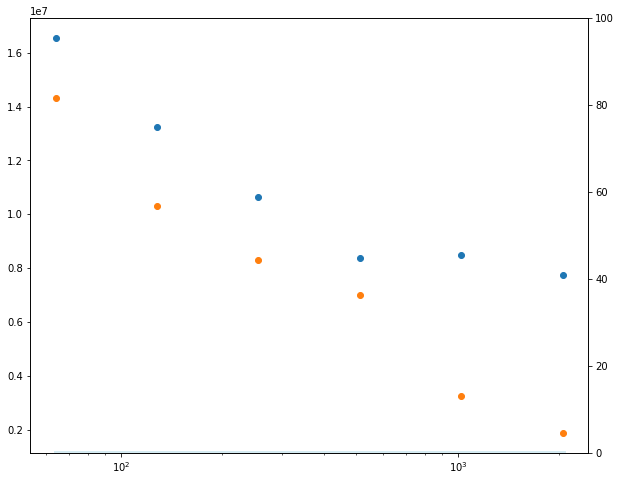

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,8))
l1 = ax.scatter(initialcon, sepnet_total, label = "sepnet absolute error")
l2 = ax.scatter(initialcon, net_total, label = "net absolute error")
# ax.set_ylabel('absolute error')
ax2 = ax.twinx()
l3 = ax2.plot(initialcon, np.maximum(np.zeros(6), (np.array(net_total)-np.array(sepnet_total))/np.array(net_total)*100), color = "lightblue", linewidth = 5.0, alpha = 0.5, label = "percentage error reduction")
# ax2.set_ylabel('percentage error reduction')
ax2.set_ylim(0,100)
plt.xscale("log")
# fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)